In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [56]:
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation
from imblearn.metrics import classification_report_imbalanced
from Visualization import Visualization

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('rebtel_w_lexicon.csv')
data = data.reset_index()
del data['index']

In [75]:
data.head(n=2)

,Rating,day,month,year,hour,minute,second,dayofweek,weekofyear,Country,...,Porter_review,Lanc_title,Lanc_review,Lems_title_review,Snow_title_review,Porter_title_review,Lanc_title_review,Rel_w_title_review,Key_country,Lex_preds
0,1,21,2,2017,9,27,7,2,8,United Kingdom,...,compani charg sever time even phone not ! conn...,charg without connect,company charg sev tim ev phon not ! connect nu...,charged without connection COMPANY charged sev...,charg without connect compani charg sever time...,charg without connect compani charg sever time...,charg without connect company charg sev tim ev...,charged without connection COMPANY charged sev...,0,1
1,1,16,2,2017,2,32,11,4,7,United States,...,top price mistakenli topup option near price t...,refund,top pric mistak topup opt near pric touch pric...,refund topped PRICE mistakenly topup option ne...,refund top price mistaken topup option near pr...,refund top price mistakenli topup option near ...,refund top pric mistak topup opt near pric tou...,refund topped PRICE mistakenly topup option ne...,1,2


In [3]:
# Build a balanced train/test set
data = data.reindex()
r1_df = data.loc[data.Rating == 1]
r2_df = data.loc[data.Rating == 2]
r3_df = data.loc[data.Rating == 3]
r4_df = data.loc[data.Rating == 4]
r5_df = data.loc[data.Rating == 5]
dfs = [r1_df, r2_df, r3_df, r4_df, r5_df]

In [4]:
t_size = 0.7

train_set = []
test_set = []

for df in dfs:
    
    train_size = int(len(df)* t_size)
    
    train_data = df[0:train_size].reset_index(drop=True)
    test_data = df[train_size:].reset_index(drop=True)
    
    train_set.append(train_data)
    test_set.append(test_data)

In [11]:
df_train = pd.concat(train_set[:],axis=0)
df_train = df_train.reset_index()

df_test = pd.concat(test_set[:],axis=0)
df_test = df_test.reset_index()

df = pd.concat([df_train,df_test],axis=0)
df = shuffle(df).reset_index()

In [10]:
# Extract true labels from data
y_data = df["Rating"].values
y_data = y_data.reshape(y_data.shape[0],)

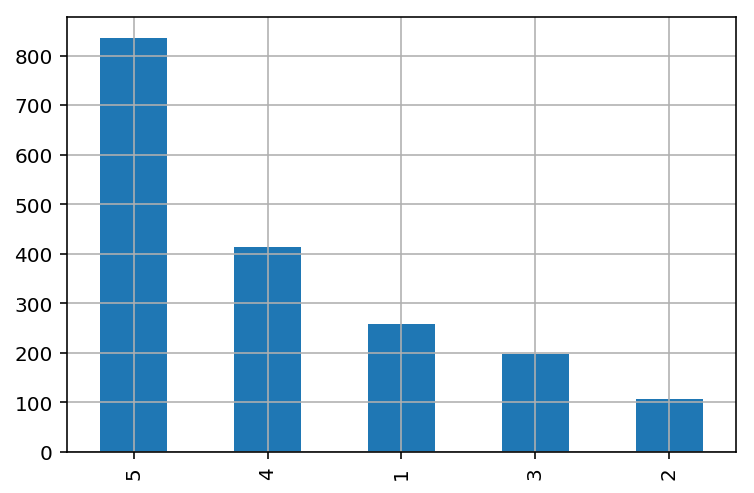

In [76]:
#Check distribution of classes
df.Rating.value_counts().plot(kind='bar',grid=True)

In [16]:
ctyNames = df.Country.unique() 
ctyNames = np.append(ctyNames,['Unkown'])
countries = {ctyNames[i]: i for i in range(0, len(ctyNames))}

In [18]:
def map_country(ctyName,countries):
    
    if ctyName in countries:
        value = countries[ctyName]
    else:
        value = countries['Unkown']

    return value

In [19]:
df['Key_country'] = [map_country(cty,countries) for cty in df.Country]

In [121]:
# Set up Vectorizer with the X most frequent words
top_words = 125 #145 
vectorizer = CountVectorizer(ngram_range=(1,2),analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None,   \
                            max_features = top_words )
RANDOM_STATE = 42

In [122]:
n_features = top_words
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')

In [123]:
#ADD MORE FEATURES
add_feats = df[['Reads','r_compound','r_negative', 'r_positive',
                'r_neutral','t_compound','t_negative', 't_positive',
                't_neutral','dayofweek','weekofyear','Key_country',
                "Useful"]]
a_feats = add_feats.values

In [124]:
#Select method to train model (Lems/Snow/Porter/Lanc)
method =  "Lanc"
add_feats = True
tfidf = False
seed = 13 

x_fts = vectorizer.fit_transform(df[method + '_title_review'])
x_fts = x_fts.toarray()

if add_feats:
    x_fts = np.concatenate((x_fts,a_feats),axis=1)


np.random.seed(seed)

train_size = 0.75
train_size = int(len(x_fts)* train_size)

x_train, y_train = x_fts[0:train_size], df['Rating'][0:train_size]
X_test, Y_test = x_fts[train_size:], df['Rating'][train_size:] 

In [125]:
if tfidf:

    t0 = time()
    tfidf = tfidf_vectorizer.fit_transform(df[method + '_title_review'])
    print("done in %0.3fs." % (time() - t0))

    x_fts = tfidf.toarray()

    if add_feats:
        x_fts = np.concatenate((x_fts,a_feats),axis=1)


    np.random.seed(seed)

    train_size = 0.75
    train_size = int(len(x_fts)* train_size)

    x_train, y_train = x_fts[0:train_size], df['Rating'][0:train_size]
    X_test, Y_test = x_fts[train_size:], df['Rating'][train_size:] 

In [126]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)

encoded_Y = encoder.transform(y_train)
encoded_Y_test = encoder.transform(Y_test)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)

In [127]:
# split into 67% for train and 33% for test
x_train, x_test, y_train, y_test = train_test_split(x_train, dummy_y_train, test_size=0.33, random_state=seed)

In [128]:
model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32, init='normal', activation='relu'))
#model.add(Dense(64, init='normal', activation='relu'))
model.add(Dense(5, init='normal', activation='sigmoid'))
# compile model for a multi-class classification problem (optimizer = adam/rmsprop/sgd)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train,y_train,validation_data=(x_test,y_test),shuffle=True, nb_epoch=80, batch_size=128)

Train on 909 samples, validate on 449 samples
Epoch 1/80
909/909 [==============================] - 0s - loss: 1.6289 - acc: 0.1540 - val_loss: 1.5884 - val_acc: 0.4499
Epoch 2/80
909/909 [==============================] - 0s - loss: 1.5717 - acc: 0.4004 - val_loss: 1.5546 - val_acc: 0.4588
Epoch 3/80
909/909 [==============================] - 0s - loss: 1.5338 - acc: 0.4521 - val_loss: 1.5151 - val_acc: 0.4788
Epoch 4/80
909/909 [==============================] - 0s - loss: 1.4901 - acc: 0.4466 - val_loss: 1.4660 - val_acc: 0.4833
Epoch 5/80
909/909 [==============================] - 0s - loss: 1.4453 - acc: 0.4466 - val_loss: 1.4184 - val_acc: 0.4833
Epoch 6/80
909/909 [==============================] - 0s - loss: 1.4212 - acc: 0.4466 - val_loss: 1.3854

In [129]:
# Final evaluation of the model
scores = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 58.50%


In [130]:
test_preds = model.predict_classes(X_test)
c_y = dummy_y_test.argmax(1)
print(classification_report_imbalanced(y_pred=test_preds,y_true=c_y))

 32/453 [=>............................] - ETA: 6s                   pre       rec       spe        f1       geo       iba       sup

          0       0.65      0.75      0.93      0.70      0.79      0.60        71
          1       0.41      0.26      0.98      0.32      0.63      0.37        27
          2       0.34      0.43      0.91      0.38      0.57      0.30        42
          3       0.39      0.47      0.79      0.43      0.57      0.31       100
          4       0.77      0.66      0.83      0.71      0.75      0.57       213

avg / total       0.61      0.58      0.85      0.59      0.69      0.48       453



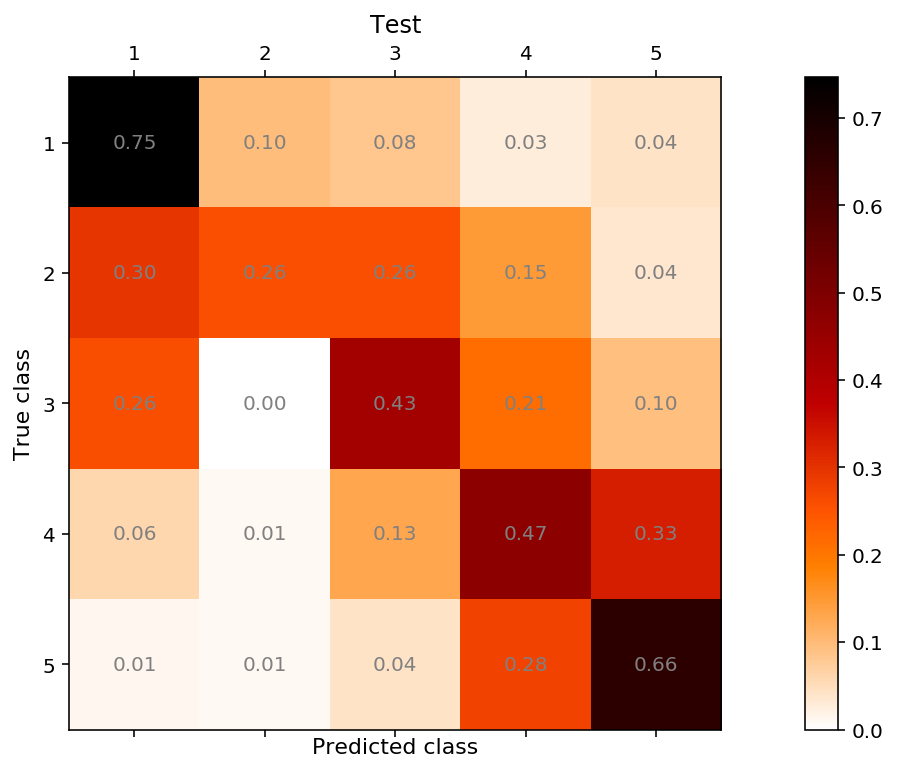

In [131]:
visual = Visualization()
visual.plot_confusion_matrix(c_y,test_preds,title='Test',color='gray')

In [50]:
predictions = pd.DataFrame(test_preds,columns=['MLP_pred'])
true = pd.DataFrame(Y_test)
true = true.reset_index()
predictions['True_label'] = true['Rating']
#Correct number of predictions  for the benefit of visualization
predictions["MLP_pred"] = [i+1 for i in predictions['MLP_pred']]

In [51]:
#Save predictions to a local file
predictions.to_csv('MLP_predictions.csv')

In [74]:
#Implementation of cross-validation
# define baseline model
def baseline_model():
    model = Sequential()
    model.add(Dense(64, input_dim=138, activation='relu'))
    model.add(Dense(32, init='normal', activation='relu'))
    model.add(Dense(5, init='normal', activation='sigmoid'))
    # compile model for a multi-class classification problem (optimizer = adam/rmsprop/sgd)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#Use cross-validation to evaluate the generalization of model
estimator = KerasClassifier(build_fn=baseline_model, nb_epoch=70, batch_size=128, verbose=0)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

results = cross_val_score(estimator,x_train,y_train, cv=kfold,scoring='average_precision')
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 41.90% (1.22%)


In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, 'best_RFC_text_SSS.pkl', compress=9)
#model_clone = joblib.load('best_SVM_text.pkl')